<a href="https://colab.research.google.com/github/victor-bastos/ThermoCycle/blob/main/THermoCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thermodynamic Cycle Calculation for a Turbine Expander Cycle Using Ethanol and LOX

## Introduction

This project presents an automated pipeline for solving thermodynamic cycles, specifically focusing on the turbine expander cycle using Ethanol and Liquid Oxygen (LOX) as propellants. The objective is to calculate the thermodynamic cycle in steady-state and at the design point to meet a specific thrust requirement. The requirement is considered met when the thrust value is within ±1% of the chosen value.

By leveraging Python and integrating with NASA's Chemical Equilibrium with Applications (CEA) software, this project automates the entire calculation process, resembling a Simulink-like approach but without the graphical interface. The steps and methods used here can be adapted to different cycles with unique specifications, making this pipeline highly versatile.

### Key Features:
- **Automated Pipeline**: The entire calculation process is automated, minimizing manual intervention and errors.
- **CEA Integration**: Combustion simulations are performed using the CEA software, with results automatically extracted and formatted.
- **Data Extraction and Tabulation**: The output from CEA is parsed using regular expressions, and the relevant parameters are stored in dataframes for easy access and analysis.
- **Comprehensive Output**: The project provides detailed tables of pressure, temperature, and mass flow rates at the entry and exit of each component, as well as performance parameters such as thrust, specific impulse, and characteristic velocity.

### Objective:
The goal is to calculate the thermodynamic cycle to satisfy the thrust requirement while providing detailed data on the thermodynamic state at various points in the cycle. This includes:
- Total pressure, total temperature, and mass flow rate at the entry and exit of all components.
- Density, molar mass, specific heat at constant pressure, and ratio of specific heats in the combustion chamber.
- Performance parameters including thrust, specific impulse at the chosen exit pressure, specific impulse in vacuum, characteristic velocity, thrust coefficient, jet velocity at the nozzle exit, speed of sound at the nozzle exit, jet Mach number, and nozzle expansion ratio.

By automating these calculations, this project aims to provide a robust and reliable tool for analyzing and optimizing thermodynamic cycles in rocket propulsion systems, adaptable to various cycle types with specific requirements.
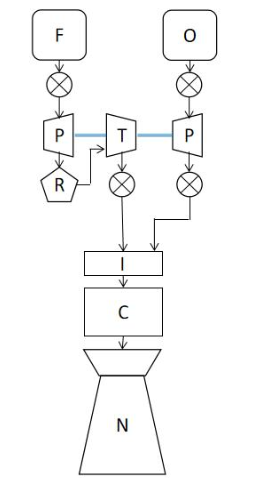

# Installing Package

In [1]:
pip install rocketcea &> /dev/null

# Defining the Fluid Class

In this section, we define the core functionality for simulating the behavior of fluids in a thermodynamic cycle. This includes creating instances of fluids, adjusting their properties through various components such as ducts, valves, pumps, and turbines, and recording the state of the fluids at each stage. The goal is to provide a flexible and automated pipeline for solving thermodynamic cycles, similar to Simulink but without a graphical interface. This pipeline can be adapted to various cycle configurations by adjusting the input parameters and following the outlined steps.


In [2]:
import pandas as pd
import numpy as np

global dataFrame
dataFrame = pd.DataFrame(columns=['Station',
                                  'Propellant',
                                  'Pressure (Pa)',
                                  'Temperature (K)',
                                  'Flow rate (kg/s)'])

class Fluid:
    # Constructor for the Fluid class with parameters for pressure, temperature, flow rate, and optional power
    def __init__(self, _name, _pressure, _temperature, _flow, _rho, _isFuel, _isPrimary=None, _location=None, _power=None, dataFrame=None):
        self.name = _name  # Attribute: fluid name
        self.pressure = _pressure  # Attribute: fluid pressure
        self.temp = _temperature  # Attribute: fluid temperature
        self.flow = _flow  # Attribute: fluid flow rate
        self.rho = _rho
        self.isFuel = _isFuel
        self.isPrimary = _isPrimary
        self.location = _location
        self.dataFrame = pd.DataFrame(columns=['Station',
                                               'Propellant',
                                               'Pressure (Pa)',
                                               'Temperature (K)',
                                               'Flow rate (kg/s)'])
        self.power = _power  # Attribute: fluid power (optional)

    # Method to print the current state of the fluid
    def PrintState(self):
        if self.power is None:
            # Formatting strings with 2 decimal places
            print("{}:\nP = {:.2f} Pa\nT = {:.2f} K\nFlow rate = {:.2f} kg/s\nNo shaft power, not passed through pump yet."
                  "\n------------------------".format(self.name, self.pressure, self.temp, self.flow))
        else:
            # Formatting strings with 2 decimal places
            print("{}:\nP = {:.2f} Pa\nT = {:.2f} K\nFlow rate = {:.2f} kg/s\nShaft power = {:.2f} W"
                  "\n------------------------".format(self.name, self.pressure, self.temp, self.flow, self.power))

    def AddRecord(self):
        if self.isFuel:
            if self.isPrimary is None:
                propellant = 'Fuel'
            elif self.isPrimary:
                propellant = 'Primary Fuel'
            else:
                propellant = 'Secondary Fuel'
        else:
            if self.isPrimary is None:
                propellant = 'Oxidizer'
            elif self.isPrimary:
                propellant = 'Primary Oxidizer'
            else:
                propellant = 'Secondary Oxidizer'

        row = [self.location,
               propellant,
               self.pressure,
               self.temp,
               self.flow]
        self.dataFrame.loc[len(self.dataFrame), self.dataFrame.columns] = row
        dataFrame.loc[len(dataFrame), dataFrame.columns] = row

    # Method to simulate a duct, adjusting pressure, temperature, and flow rate
    def Duct(self, deltaP, deltaT, deltaV=0):
        self.location = 'Duct'
        self.pressure = self.pressure * (1 - deltaP)  # Adjusting pressure
        self.temp = self.temp * (1 - deltaT)  # Adjusting temperature
        self.flow = self.flow * (1 - deltaV)  # Adjusting flow rate
        self.AddRecord()

    # Methods to simulate valves, adjusting pressure, temperature, and flow rate
    def Valve(self, deltaP, deltaT, identifier='', deltaV=0):
        self.location = 'Valve Inlet ' + identifier
        self.AddRecord()
        self.pressure = self.pressure * (1 - deltaP)
        self.temp = self.temp * (1 - deltaT)
        self.flow = self.flow * (1 - deltaV)
        self.location = 'Valve Outlet ' + identifier
        self.AddRecord()

    # Methods to simulate an injector, adjusting pressure, temperature, and flow rate
    def Injector(self, deltaP, deltaT, deltaV=0):
        self.location = 'Injector Inlet'
        self.AddRecord()
        self.pressure = self.pressure * (1 - deltaP)
        self.temp = self.temp * (1 - deltaT)
        self.flow = self.flow * (1 - deltaV)
        self.location = 'Injector Outlet'
        self.AddRecord()

    # Methods to simulate a heat exchanger, adjusting pressure, temperature, and flow rate
    def HeatExchanger(self, deltaP, deltaT, deltaV=0):
        self.location = 'Heat Exchanger Inlet'
        self.AddRecord()
        self.pressure = self.pressure * (1 - deltaP)
        self.temp = self.temp * (1 - deltaT)
        self.flow = self.flow * (1 - deltaV)
        self.location = 'Heat Exchanger Outlet'
        self.AddRecord()

    # Methods to simulate a cooler, adjusting pressure, temperature, and flow rate
    def Cooler(self, deltaP, deltaT, deltaV=0):
        self.location = 'Cooler Inlet'
        # Relative temperature increase
        self.AddRecord()
        self.pressure = self.pressure * (1 - deltaP)
        self.temp = self.temp * (1 + deltaT)  # Temperature increase
        self.flow = self.flow * (1 - deltaV)
        self.location = 'Cooler Outlet'
        self.rho = self.pressure / (180.08 * self.temp)
        self.AddRecord()

    # Method to simulate a pump, updating pressure and calculating shaft power
    def Pump(self, pressureRatio, efficiency):
        self.location = 'Pump Inlet'
        self.AddRecord()
        self.location = 'Pump'
        p1 = self.pressure
        self.pressure = p1 * pressureRatio  # Updating pressure
        # Calculating shaft power
        self.power = self.flow * (self.pressure - p1) / (efficiency * self.rho)
        self.location = 'Pump Outlet'
        self.AddRecord()

    # Method to simulate a turbine, updating temperature, pressure, and power
    def Turbine(self, totalPower, efficiency, transmissionEfficiency, cp, gamma):
        self.location = 'Turbine Inlet'
        self.AddRecord()
        T1 = self.temp
        # Updating temperature
        self.temp = T1 - totalPower / (transmissionEfficiency * self.flow * cp)
        # Updating pressure based on a complex formula
        self.pressure = self.pressure * (1 - ((T1 - self.temp) / (efficiency * T1)) ** (gamma / (gamma - 1)))
        self.location = 'Turbine Outlet'
        self.AddRecord()

    # Method to split the fluid flow into two components
    def FlowSplitter(self, secondaryFraction, deltaP=0, deltaT=0):
        self.location = 'Flow Splitter Inlet'
        self.AddRecord()
        self.pressure = self.pressure * (1 - deltaP)
        self.temp = self.temp * (1 - deltaT)
        # Creating two secondary and primary fluids with adjusted flow rates
        self.location = 'Flow Splitter Outlet'
        secondary = Fluid('Secondary', self.pressure, self.temp, self.flow * secondaryFraction, self.rho, self.isFuel, False, self.location)
        primary = Fluid('Primary', self.pressure, self.temp, self.flow * (1 - secondaryFraction), self.rho, self.isFuel, True, self.location)
        primary.AddRecord()
        secondary.AddRecord()
        return primary, secondary  # Returns the two fluids

    # Method to connect two fluid flows and create a resultant fluid
    def FlowConnector(self, secondFluid):
        self.location = 'Flow Connector Inlet'
        secondFluid.location = 'Flow Connector Inlet'
        self.AddRecord()
        secondFluid.AddRecord()
        totalFlow = self.flow + secondFluid.flow
        totalPressure = (self.flow * self.pressure + secondFluid.flow * secondFluid.pressure) / totalFlow
        resultantFluid = Fluid(self.name, totalPressure, self.temp, totalFlow, self.rho, self.isFuel, self.isPrimary)
        resultantFluid.location = 'Flow Connector Outlet'
        resultantFluid.AddRecord()
        return resultantFluid  # Returns the resultant fluid


# Applying to the problem

## Problem definitions

In [4]:
# Defining the percentage variations for pressure, temperature, and flow rate
deltaP = 0.03  # Total pressure variation of 3%
deltaT = 0.01  # Total temperature variation of 1%
deltaV = 0.0192  # Flow rate variation of 1.92%
deltaPinjetor = 0.21  # Pressure variation in injectors of 21%

# Defining the pressure ratios and efficiencies for the pumps
pressure_ratio_fuel_pump = 25  # Pressure ratio for the fuel pump
pressure_ratio_oxidizer_pump = 20  # Pressure ratio for the oxidizer pump
efficiency_fuel_pump = 0.9  # Efficiency of the fuel pump
efficiency_oxidizer_pump = 0.85  # Efficiency of the oxidizer pump

# Defining the percentage variations for pressure and temperature in the regenerative cooler
deltaP_cooler = 0.20  # Total pressure variation of 20%
deltaT_cooler = 0.35  # Total temperature variation of 35%

# Defining the fraction of the LOX flow to the preburner
secondary_fraction = 0.01088  # Fraction of 1.088% of the total flow to the preburner

# Defining the efficiencies for the turbine and mechanical transmission efficiency
efficiency_turbine = 0.85  # Efficiency of the turbine
mechanical_efficiency = 0.98  # Mechanical transmission efficiency

# After becoming gas
cp_ideal = 14400  # In J/kgK
gamma_ideal = 1.41  # Ratio of specific heats

##Initializing the Fluids

In [5]:
# Creating an instance of the fluid to represent the fuel (Ethanol)
fuel = Fluid(
    _name='Ethanol',  # Name of the fluid
    _pressure=1500000,  # Total pressure of the fluid in Pa
    _temperature=298.15,  # Total temperature of the fluid in K
    _flow=20,  # Flow rate of the fluid in kg/s
    _rho=789,  # Density of the fluid in kg/m³
    _isFuel=True,  # Indicator that this is a fuel (True)
    _isPrimary=True  # Indicator that this is the primary fuel
)

# Creating an instance of the fluid to represent the oxidizer (LOX)
oxidizer = Fluid(
    _name='LOX',  # Name of the fluid
    _pressure=550000,  # Total pressure of the fluid in Pa
    _temperature=90.18,  # Total temperature of the fluid in K
    _flow=100,  # Flow rate of the fluid in kg/s
    _rho=1170,  # Density of the fluid in kg/m³
    _isFuel=False,  # Indicator that this is not a fuel (False)
    _isPrimary=True  # Indicator that this is the primary oxidizer
)

## Solving the Cycle

In [6]:
# Perform pressure, temperature, and flow rate adjustments on fuel and oxidizer fluids through a duct
fuel.Duct(deltaP, deltaT, deltaV)
oxidizer.Duct(deltaP, deltaT, deltaV)

# Perform pressure, temperature, and flow rate adjustments on fluids after a valve, identifying as "Initial"
fuel.Valve(deltaP, deltaT, 'Initial', deltaV)
oxidizer.Valve(deltaP, deltaT, 'Initial', deltaV)

# Perform another pressure, temperature, and flow rate adjustment on fuel and oxidizer fluids through a duct
fuel.Duct(deltaP, deltaT, deltaV)
oxidizer.Duct(deltaP, deltaT, deltaV)

# Perform the pumping process on fuel and oxidizer fluids, adjusting pressures and calculating powers
fuel.Pump(pressure_ratio_fuel_pump, efficiency_fuel_pump)
oxidizer.Pump(pressure_ratio_oxidizer_pump, efficiency_oxidizer_pump)

# Perform a cooling process on the fuel fluid, adjusting pressure and increasing temperature
fuel.Cooler(deltaP_cooler, deltaT_cooler)

# Simulate a turbine process, adjusting pressures, temperatures, and powers
# The total power is the sum of the powers of the fuel and oxidizer fluids
fuel.Turbine(totalPower=fuel.power + oxidizer.power,
             efficiency=efficiency_turbine, transmissionEfficiency=mechanical_efficiency,
             cp=cp_ideal, gamma=gamma_ideal)

# Perform another pressure, temperature, and flow rate adjustment on fuel and oxidizer fluids through a duct
fuel.Duct(deltaP, deltaT, deltaV)
oxidizer.Duct(deltaP, deltaT, deltaV)

# Perform pressure, temperature, and flow rate adjustments on fluids after a valve, identifying as "Final"
fuel.Valve(deltaP, deltaT, 'Final', deltaV)
oxidizer.Valve(deltaP, deltaT, 'Final', deltaV)

# Perform another pressure, temperature, and flow rate adjustment on fuel and oxidizer fluids through a duct
fuel.Duct(deltaP, deltaT, deltaV)
oxidizer.Duct(deltaP, deltaT, deltaV)

# Perform the injection process on fuel and oxidizer fluids, adjusting pressures and temperatures
fuel.Injector(deltaPinjetor, deltaT)
oxidizer.Injector(deltaPinjetor, deltaT)


In [7]:
# Define a function to format numbers with two decimal places
def format_number(number):
    return f'{number:.2f}'

# Apply formatting to the DataFrame for columns that contain numerical data
numeric_columns = ['Pressure (Pa)', 'Temperature (K)', 'Flow rate (kg/s)']
dataFrame[numeric_columns] = dataFrame[numeric_columns].applymap(format_number)

# Display the formatted DataFrame
dataFrame


,Station,Propellant,Pressure (Pa),Temperature (K),Flow rate (kg/s)
0,Duct,Primary Fuel,1455000.00,295.17,19.62
1,Duct,Primary Oxidizer,533500.00,89.28,98.08
2,Valve Inlet Initial,Primary Fuel,1455000.00,295.17,19.62
3,Valve Outlet Initial,Primary Fuel,1411350.00,292.22,19.24
4,Valve Inlet Initial,Primary Oxidizer,533500.00,89.28,98.08
5,Valve Outlet Initial,Primary Oxidizer,517495.00,88.39,96.20
6,Duct,Primary Fuel,1369009.50,289.29,18.87
7,Duct,Primary Oxidizer,501970.15,87.50,94.35
8,Pump Inlet,Primary Fuel,1369009.50,289.29,18.87
9,Pump Outlet,Primary Fuel,34225237.50,289.29,18.87


## Combustion with CEA NASA

In [10]:
from rocketcea.cea_obj import CEA_Obj, add_new_fuel, add_new_oxidizer, add_new_propellant

card_str_ox = """
oxid O2(L) O 2 wt%=78.0
h,cal=-3102.0 t(k)= 90.18
oxid H2O(g) H 2.0 O 1.0 wt%=22.0
h,cal=-68308 t(k)=3069.92
"""

#add_new_oxidizer('oxidante', card_str_ox )

card_str = """
fuel C2H5OH(g) C 2.0 H 6.0 O 1.0 wt%=100.0
h,cal=-66370.0 t(k)= """ + str(fuel.temp) + """
"""

add_new_fuel('fuel', card_str )

In [12]:
from rocketcea.cea_obj import CEA_Obj

# Instance with the oxidizer and fuel
ispObj = CEA_Obj(oxName=oxidizer.name, fuelName=fuel.name)

# Calculate quantities of interest
P_camara = (fuel.pressure * fuel.flow + oxidizer.pressure * oxidizer.flow) / (fuel.flow + oxidizer.flow)
P_camara_bar = P_camara / 100000  # Convert pressure to bar
P_e = 5000  # Exit pressure in bar
P_cOvP_e = P_camara_bar / P_e
mass_ratio = oxidizer.flow / fuel.flow

# Generate output with other data
s = ispObj.get_full_cea_output(
    Pc=P_camara_bar,         # Chamber pressure
    PcOvPe=P_cOvP_e,         # Chamber pressure to exit pressure ratio
    MR=mass_ratio,           # Mass ratio of oxidizer to fuel
    eps=40.0,                # Parameter for expansion ratio
    short_output=1,          # Short output for simplicity
    pc_units='bar'           # Units for chamber pressure
)

# Print the output from the CEA
print(s)



 *******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA, OCTOBER 18, 2002
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************



 reac
  fuel C2H5OH(L)   C 2 H 6 O 1
  h,cal=-66370.0      t(k)=298.15       wt%=100.
  oxid O2(L)  O 2
  h,cal=-3102.      t(k)=90.18       wt%=100.
  
 prob case=RocketCEA,
  rocket equilibrium   p,bar=93.223402,  pi/p=0.018645,  supar=40.000000,
  o/f=5.000000,
  
  
 output calories  short  transport
 end






              THEORETICAL ROCKET PERFORMANCE ASSUMING EQUILIBRIUM

           COMPOSITION DURING EXPANSION FROM INFINITE AREA COMBUSTOR

 Pinj =  1352.1 PSIA
 CASE = RocketCEA,     

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)      

## Regular Expressions to Automate Result

In [14]:
import re

# Using regular expressions to extract relevant information
density_match = re.search(r"RHO, G/CC\s+([-0-9.]+)", s)
molar_mass_match = re.search(r"M, \(1/n\)\s+([-0-9.]+)", s)
gamma_match = re.search(r"GAMMAs\s+([-0-9.]+)", s)
cp_match = re.search(r"Cp, CAL/\(G\)\(K\)\s+([-0-9.]+)", s)
isp_match = re.search(r"Isp, LB-SEC/LB\s+([-0-9.]+)", s)
ivac_match = re.search(r"Ivac,LB-SEC/LB\s+([-0-9.]+)", s)
cstar_match = re.search(r"CSTAR, FT/SEC\s+([-0-9.]+)", s)
cf_match = re.search(r"CF\s+([-0-9.]+)", s)

# Getting the corresponding values
density = density_match.group(1) if density_match else None
molar_mass = molar_mass_match.group(1) if molar_mass_match else None
gamma = gamma_match.group(1) if gamma_match else None
cp = cp_match.group(1) if cp_match else None
isp = float(isp_match.group(1)) if isp_match else None
ivac = ivac_match.group(1) if ivac_match else None
cstar = cstar_match.group(1) if cstar_match else None
cf = cf_match.group(1) if cf_match else None

# Calculating thrust
thrust = isp * 9.80 * (fuel.flow + oxidizer.flow)

# Creating the DataFrame for the Parameters Table
data = {
    'PARAMETER': [
        'Gas Density (rho)',
        'Gas Molar Mass (M)',
        'Gas Specific Heats Ratio (gamma)',
        'Gas Specific Heat at Constant Pressure (cp)',
        'Engine Thrust',
        'Engine Specific Impulse (Isp)',
        'Engine Specific Impulse in Vacuum (Ivac)',
        'Engine Characteristic Velocity (cstar)',
        'Engine Thrust Coefficient (cf)'
    ],
    'VALUE': [
        density,
        molar_mass,
        gamma,
        cp,
        np.round(thrust, 2),
        isp,
        ivac,
        cstar,
        cf
    ],
    'UNIT': [
        'G/CC',
        '1/n',
        '-',
        'CAL/(G)(K)',
        'N',
        's',
        's',
        'm/s',
        '-'
    ]
}

parameters_table = pd.DataFrame(data)
parameters_table


,PARAMETER,VALUE,UNIT
0,Gas Density (rho),1.1422-2,G/CC
1,Gas Molar Mass (M),29.587,1/n
2,Gas Specific Heats Ratio (gamma),1.1568,-
3,Gas Specific Heat at Constant Pressure (cp),0.6106,CAL/(G)(K)
4,Engine Thrust,100080.15,N
5,Engine Specific Impulse (Isp),95.6,s
6,Engine Specific Impulse in Vacuum (Ivac),177.8,s
7,Engine Characteristic Velocity (cstar),4626.1,m/s
8,Engine Thrust Coefficient (cf),0.6650,-
